In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
module = fc.eightb.preselection.ranked_quadh
signal = ObjIter([Tree(fn, use_gen=False) for fn in module.signal_list[::3]])
bkg = ObjIter([Tree(module.QCD_B_List, use_gen=False), Tree(module.TTJets, use_gen=False)])

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


In [4]:
(signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ptordered=True))

[None, None, None, None, None]

In [5]:
def relative_btag(t):
  btagavg = ak.mean(t.jet_btag,axis=-1)
  btagstd = ak.std( t.jet_btag,axis=-1)
  relbtag = (t.jet_btag-btagavg)
  btagmulti = { f'n_{wplabels[wp+1]}_btag':ak.sum(t.jet_btag>jet_btagWP[wp+1],axis=-1) for wp in range(3)}
  t.extend(
    btagavg=btagavg,
    btagstd=btagstd,
    jet_relbtag=relbtag,
    **btagmulti
  )
(signal+bkg).apply(relative_btag)

[None, None, None, None, None]

In [6]:
varinfo.jet_btag=dict(bins=(0,1,30))
varinfo.jet_relbtag=dict(bins=(-1,1,30))

100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


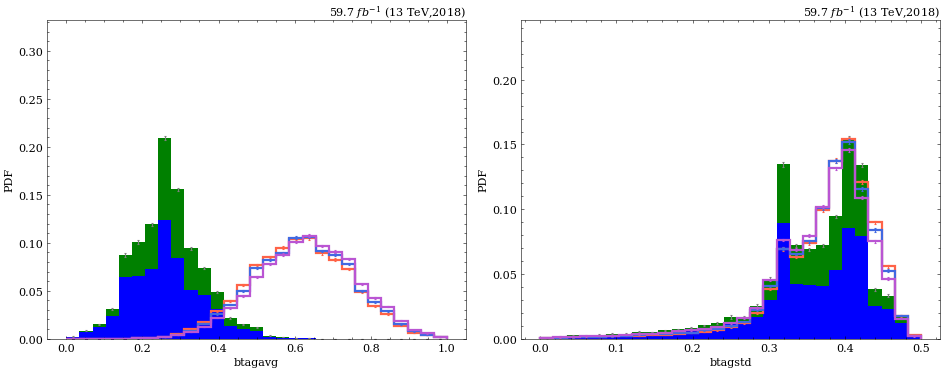

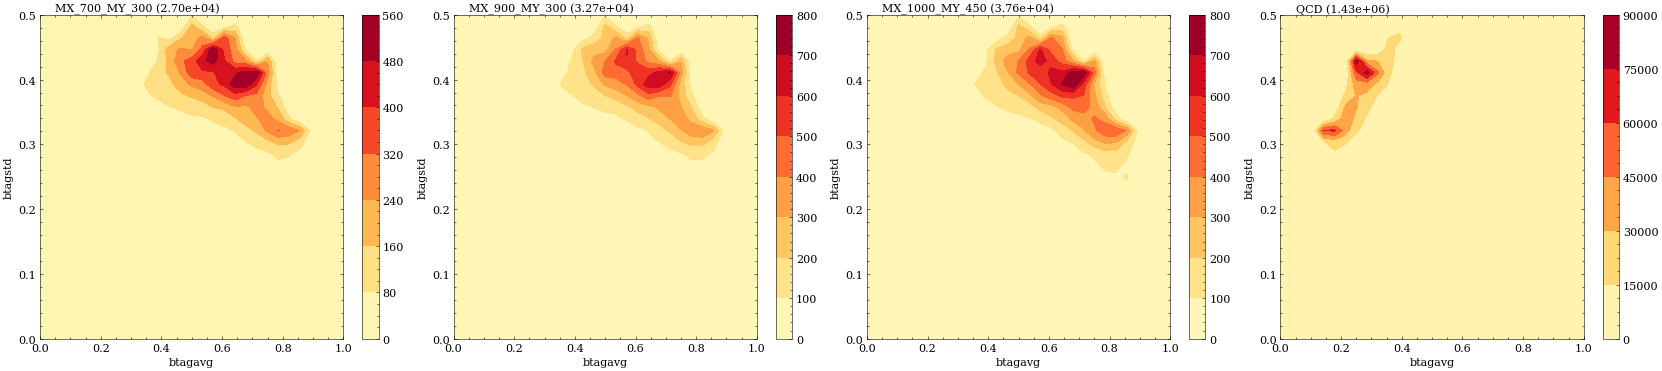

In [7]:
varinfo.btagavg=dict(bins=(0,1,30))
varinfo.btagstd=dict(bins=(0,0.5,30))

study.quick(
  signal+bkg, stacked=True,
  efficiency=True,
  varlist=['btagavg','btagstd'],
)

fig, axs = study.quick2d(
  signal, 
  varlist=['btagavg','btagstd'],
  return_figax=True,
  contour=True,
  dim=(-1,4),
)

study.quick2d_region(
  bkg,
  varlist=['btagavg','btagstd'],
  figax=(fig,axs.flat[-1]),
  contour=True,
)

100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


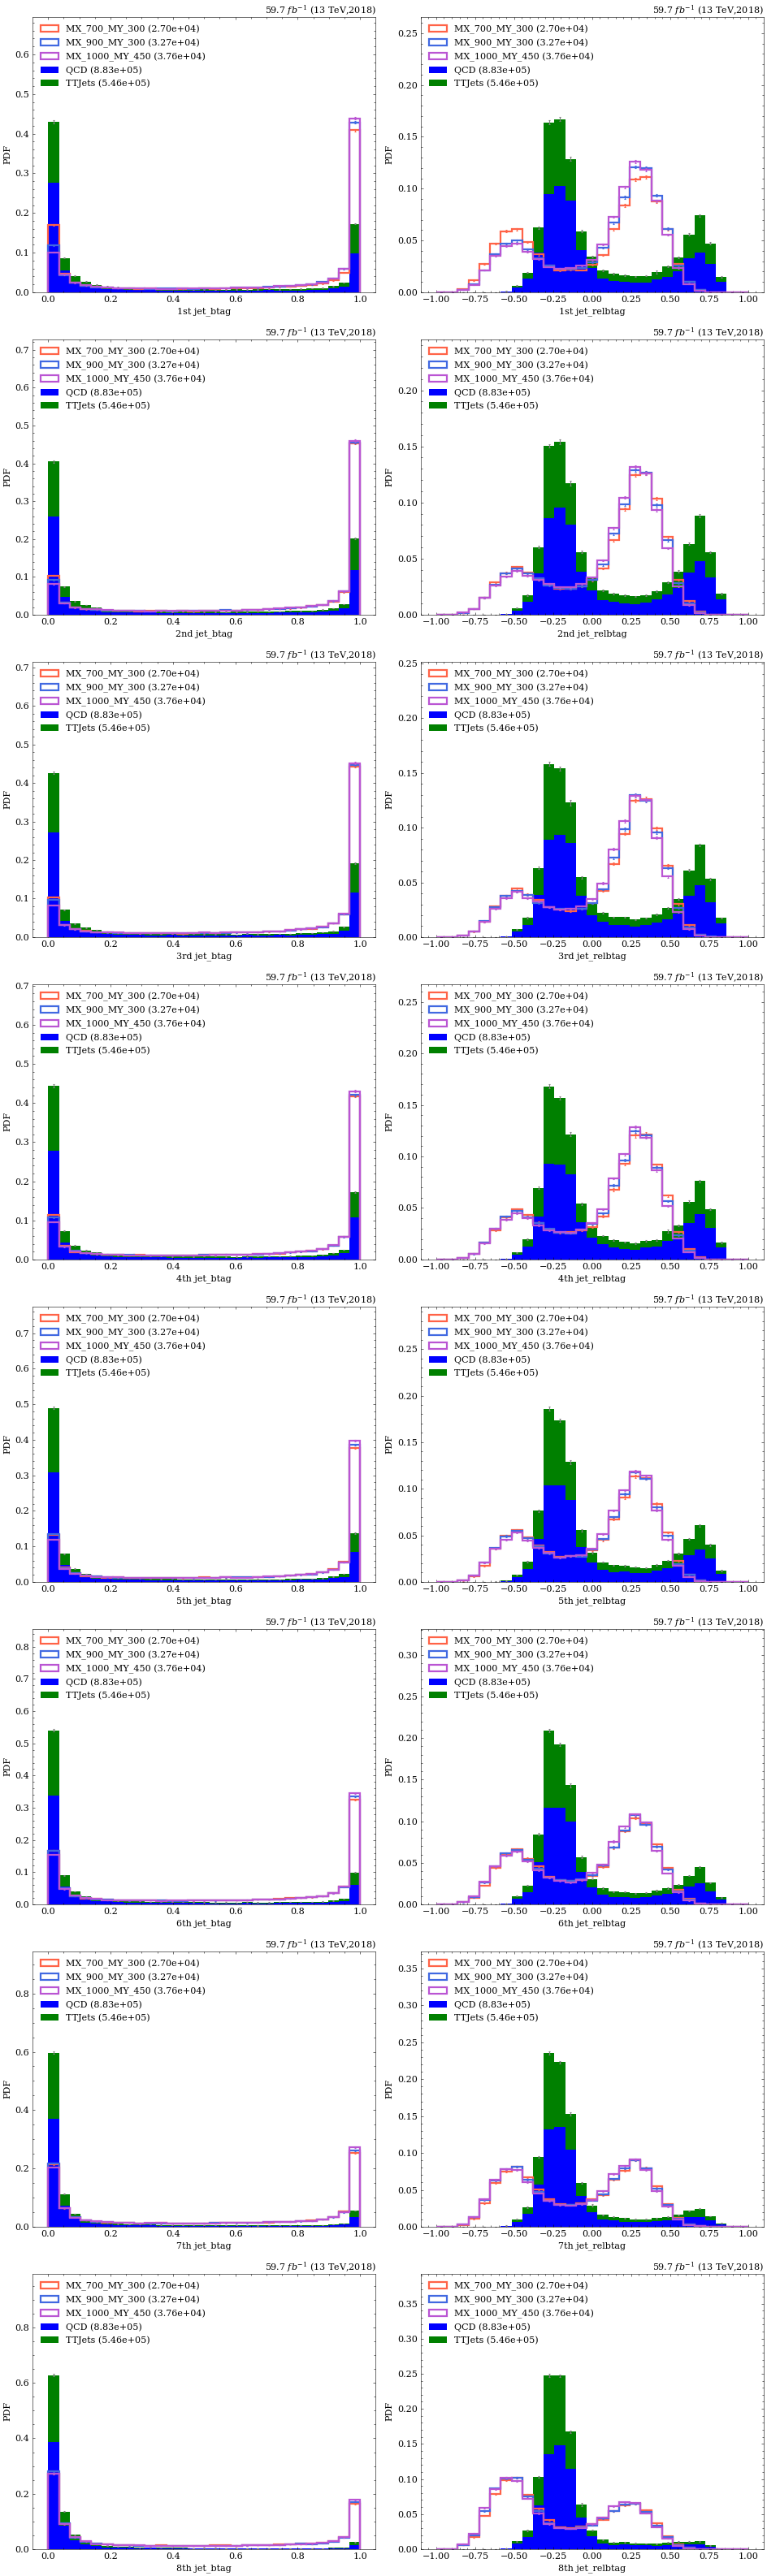

In [8]:
fig, axs = study.get_figax(2*8, dim=(8,2))
for i in range(8):
  study.quick(
    signal+bkg, legend=True, stacked=True,
    varlist=[f'jet_btag[:,{i}]', f'jet_relbtag[:,{i}]'],
    # xlabels=[f'{ordinal(i+1)} jet_btag', f'{ordinal(i+1)} jet_relbtag'],
    efficiency=True,

    figax=(fig,axs.flat[2*i:2*i+2])
  )

100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


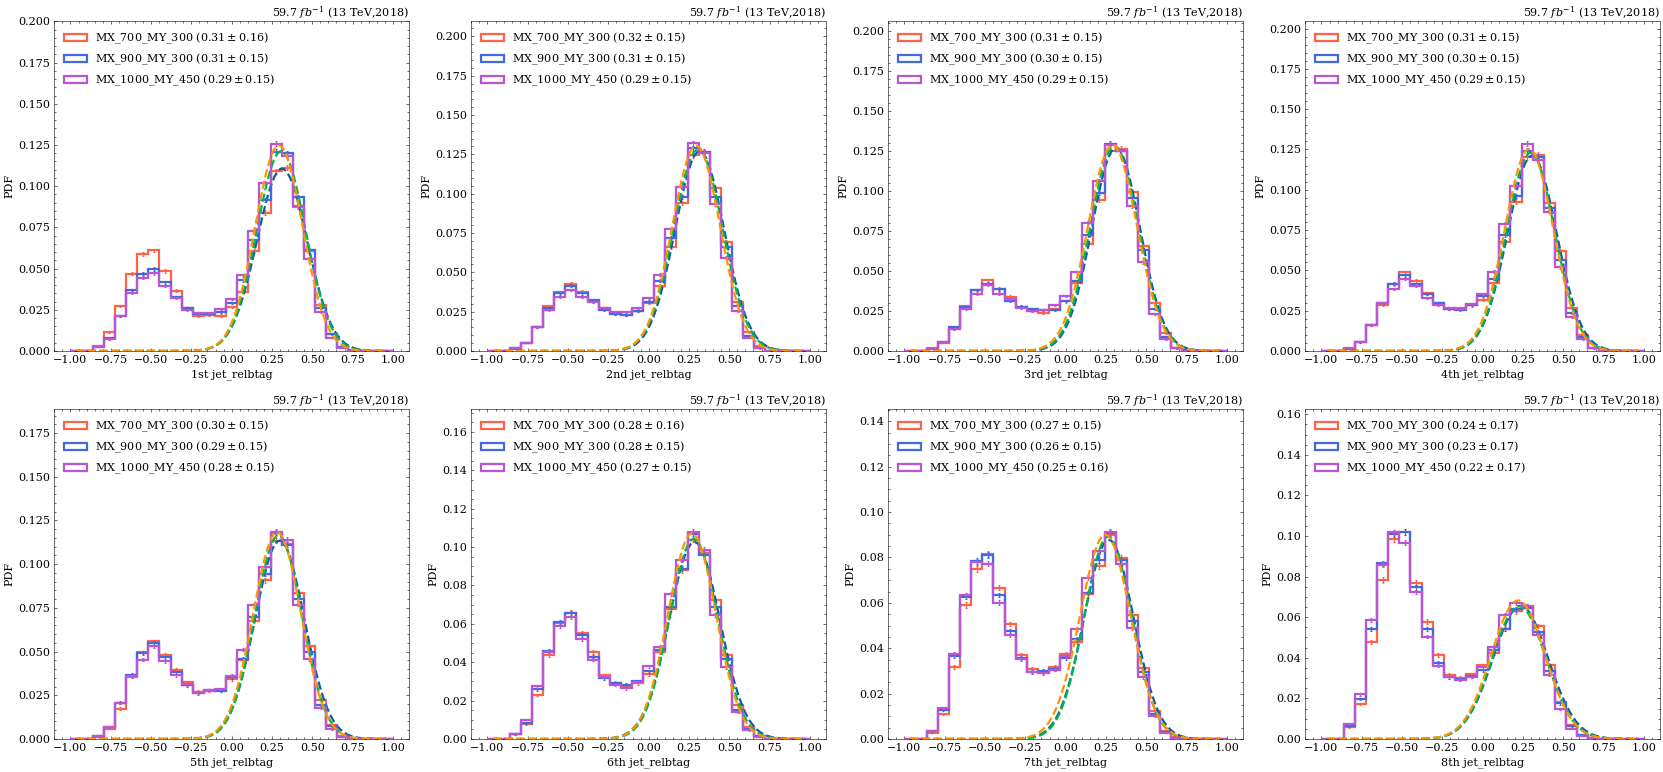

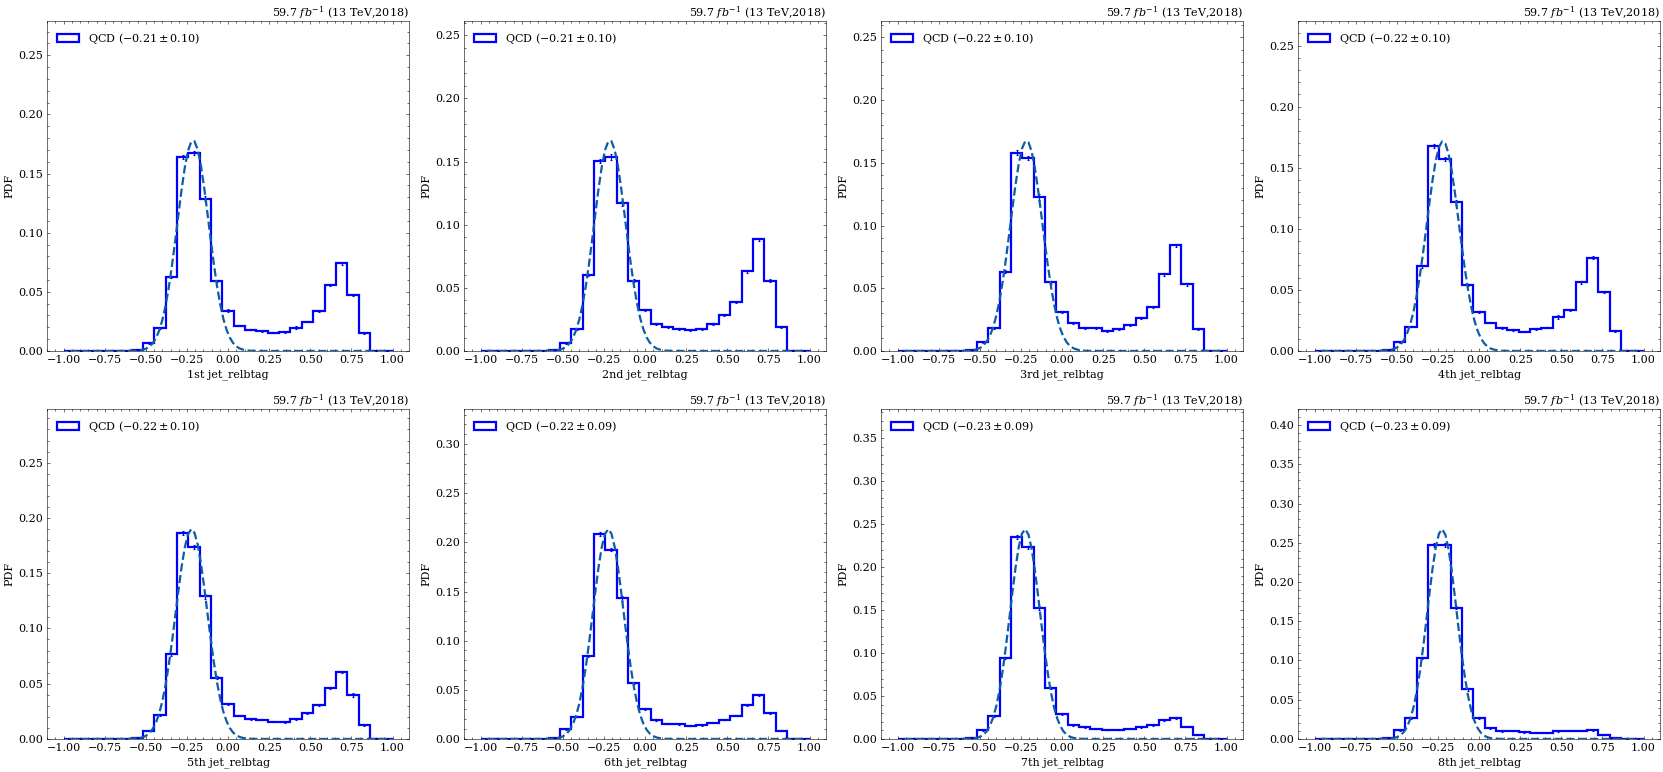

In [10]:
study.quick(
  signal, legend=True, h_label_stat="${fit.mu:0.2f}\pm{fit.sigma:0.2f}$",
  varlist=[f'jet_relbtag[:,{i}]' for i in range(8)],
  h_fit='gaussian', h_fit_peak=True, h_fit_bounds=(0,0.5), h_fit_show=True,
  efficiency=True,
)
study.quick_region(
  bkg, legend=True, h_label_stat="${fit.mu:0.2f}\pm{fit.sigma:0.2f}$",
  varlist=[f'jet_relbtag[:,{i}]' for i in range(8)],
  h_fit='gaussian', h_fit_peak=True, h_fit_bounds=(-0.5,0), h_fit_show=True,
  efficiency=True,
)

100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


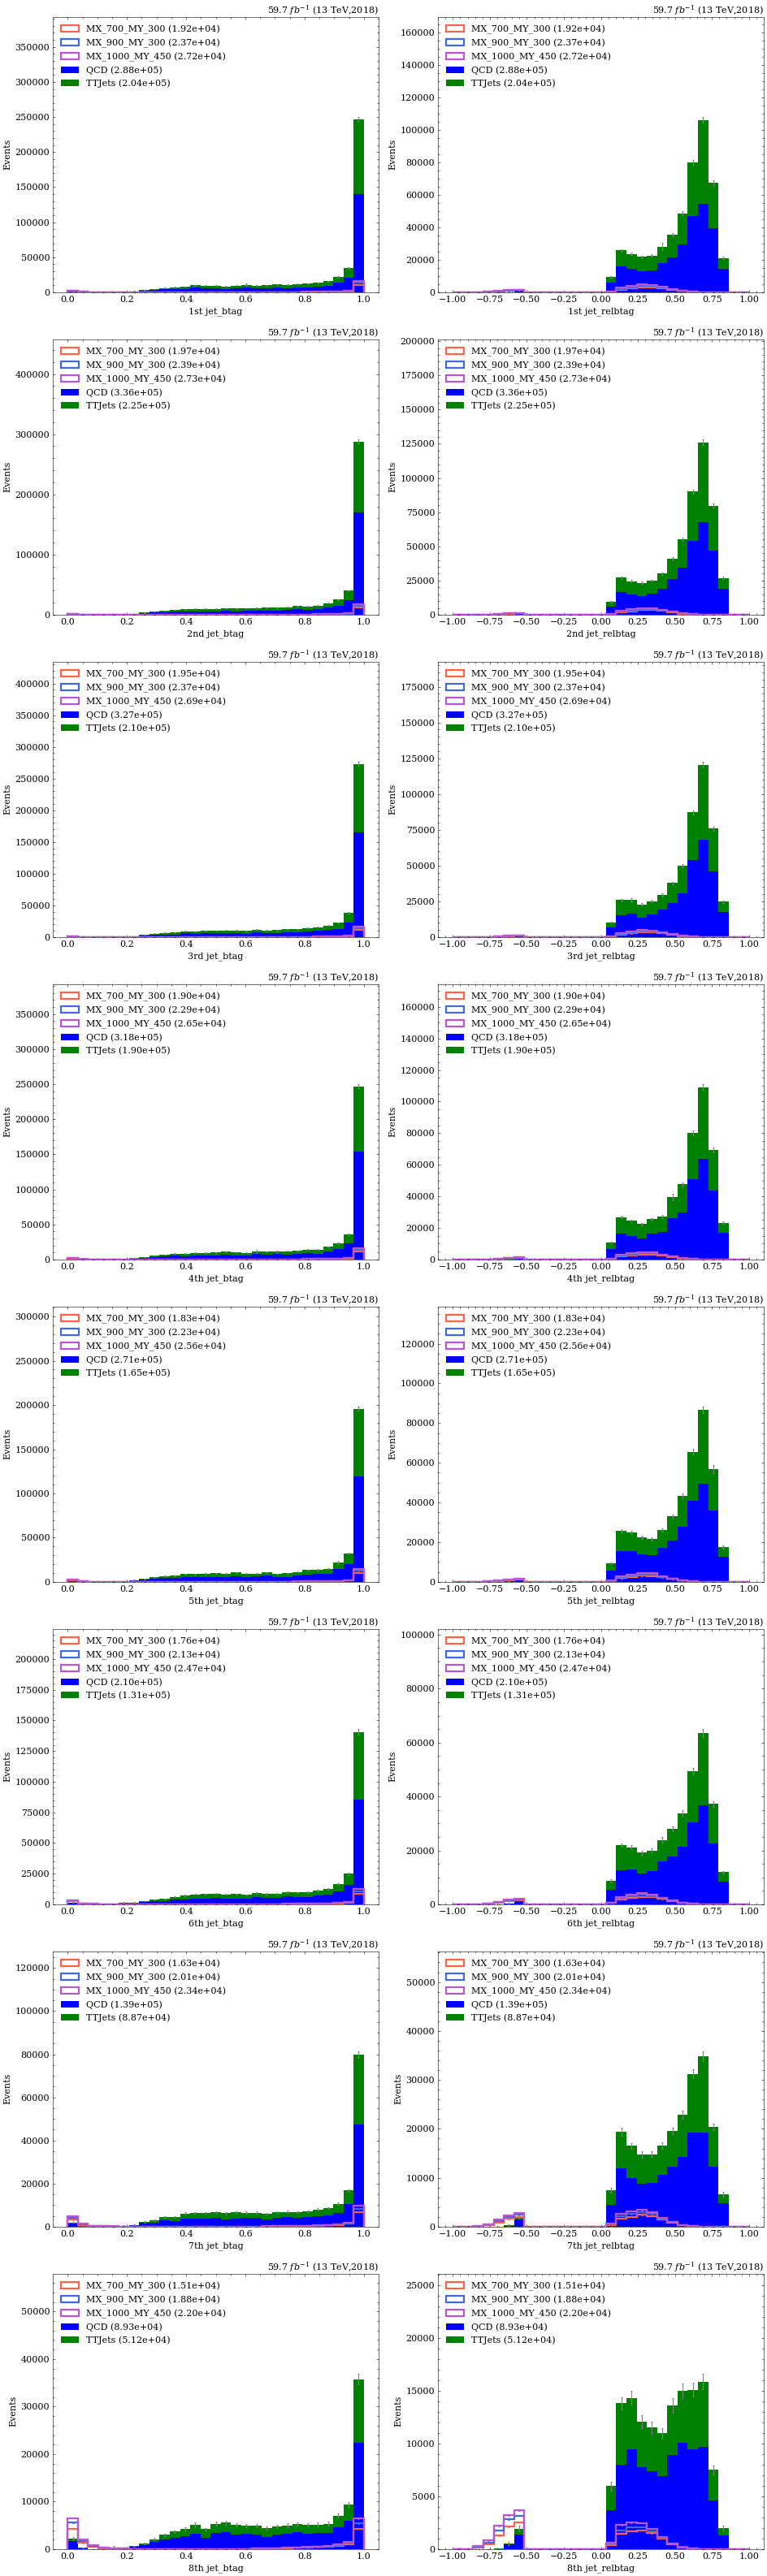

In [13]:
fig, axs = study.get_figax(2*8, dim=(8,2))
for i in range(8):
  study.quick(
    signal+bkg, legend=True, stacked=True,
    masks=lambda t : np.abs(t.jet_relbtag[:,i]+0.22) > 3*0.1,
    varlist=[f'jet_btag[:,{i}]', f'jet_relbtag[:,{i}]'],
    # efficiency=True,

    figax=(fig,axs.flat[2*i:2*i+2])
  )

100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


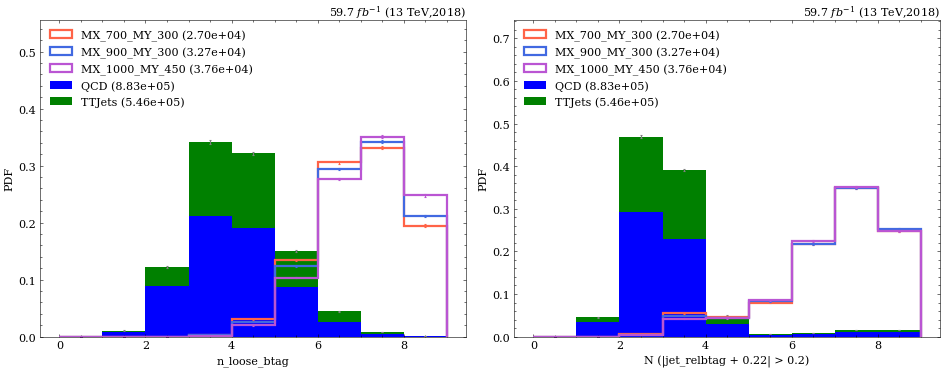

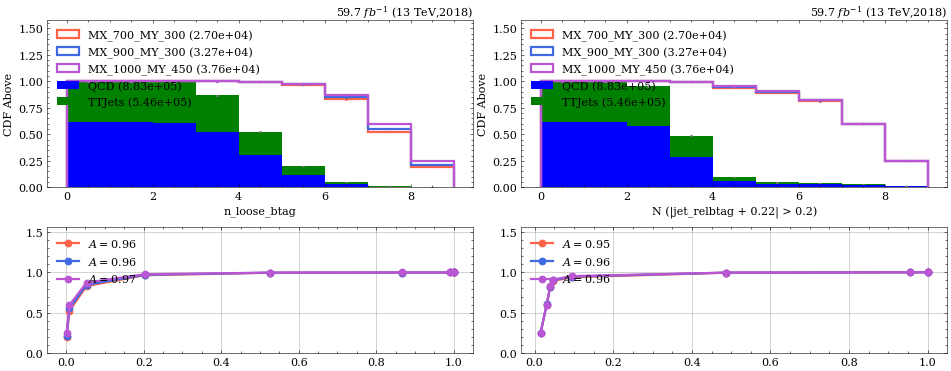

In [22]:
class n_relbtag(ObjTransform):
  def init(self):
    transforms = {
      np.abs:"|%s|"
    }

    def centers(center):
      if center == 0: return ""
      if center < 0 : return f" + {-center:0.2}"
      if center > 0 : return f" - { center:0.2}"

    self.xlabel =[
      (transforms.get(transform, "%s") % (f"jet_relbtag{centers(center)}")) + f" > {bounds:0.2}"
      for transform, center, bounds in self.cuts
    ]
    self.xlabel = "N (" + " | ".join(self.xlabel) + ")"
    self.bins = np.arange(10)
  def __call__(self, t):
    mask = None
    for transform, center, bounds in self.cuts:
      if transform is None: transform = lambda v : v
      _mask = transform(t.jet_relbtag - center) > bounds
      if mask is None: mask = _mask 
      else: mask = mask | _mask

    return ak.sum(mask,axis=-1)


relbtag_multi = n_relbtag(cuts=[
    (np.abs, -0.22, 2*0.1),
])

study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=['n_loose_btag',relbtag_multi],
  efficiency=True,
)

study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=['n_loose_btag',relbtag_multi],
  cumulative=-1, correlation=True,
)

100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


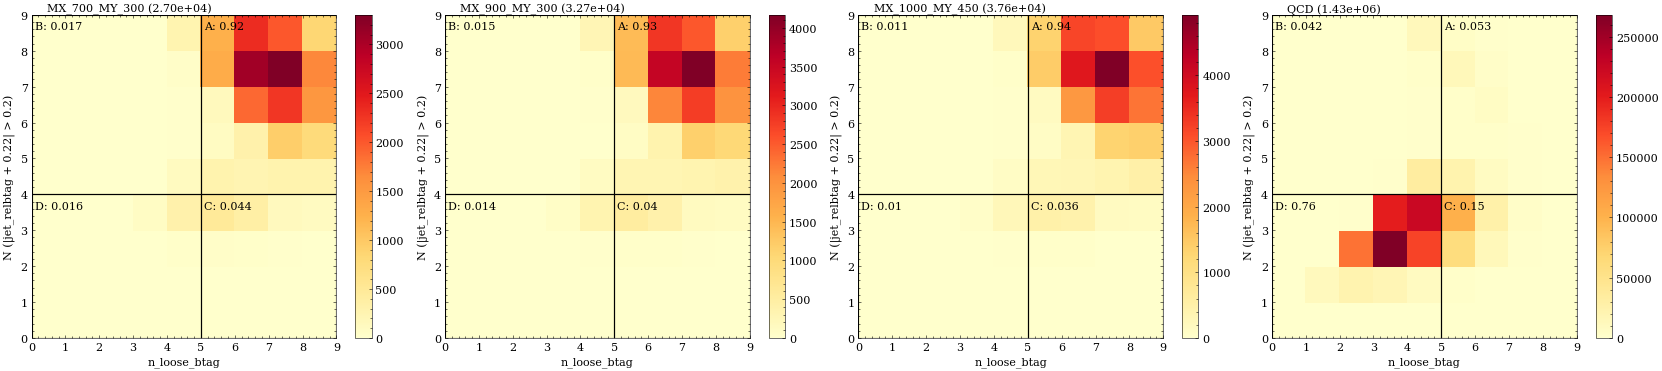

In [24]:
fig, axs = study.get_figax(4, dim=(-1,4))

get_abcd = draw_abcd(x_r=(0,5,9), y_r=(0,4,9))

study.quick2d(
  signal,
  varlist=['n_loose_btag', relbtag_multi],
  # contour=True,
  exe=get_abcd,
  figax=(fig, axs.flat[:3])
)

study.quick2d_region(
  bkg,
  varlist=['n_loose_btag',relbtag_multi],
  # contour=True,
  exe=get_abcd,
  figax=(fig, axs.flat[3]),
)


In [136]:
def get_region_score(x, y):
  bdt = ABCD(
  features=['X_pt'],
  a = lambda t : (t.n_loose_btag >  x) & (t.relbtag_multi >  y),
  b = lambda t : (t.n_loose_btag <= x) & (t.relbtag_multi >  y),
  c = lambda t : (t.n_loose_btag >  x) & (t.relbtag_multi <= y),
  d = lambda t : (t.n_loose_btag <= x) & (t.relbtag_multi <= y),
  )

  bdt.train(bkg, reweight=False)
  return np.abs(bdt.results(bkg)['k_factor_score'])

In [137]:
X = np.arange(1,7)
Y = np.arange(1,5)
X, Y = np.meshgrid(X, Y)

In [138]:
def best_region(center=0.8, width=0.7):
  relbtag_multi = n_relbtag(cuts=[(np.abs, center, width)])
  bkg.apply(lambda t : t.extend(relbtag_multi=relbtag_multi(t)))
  Z = np.vectorize(get_region_score)(X,Y)
  z = np.min(Z)
  x = X[Z==z][0]
  y = Y[Z==z][0]
  return (x, y, z)

In [141]:
get_region_score(4,2)

0.6573432513873793

In [74]:
features = [ f'{obj}_{var}' for obj in ['X']+eightb.ylist for var in ('m','pt') ]
bdt = ABCD(
  features=['X_pt'],
  a = lambda t : (t.n_loose_btag >  4) & (relbtag_multi(t) >  1),
  b = lambda t : (t.n_loose_btag <= 4) & (relbtag_multi(t) >  1),
  c = lambda t : (t.n_loose_btag >  4) & (relbtag_multi(t) <= 1),
  d = lambda t : (t.n_loose_btag <= 4) & (relbtag_multi(t) <= 1),
)

bdt.train(bkg, reweight=False)
bdt.print_results(bkg)

--- ABCD Results ---
k = 1.520e-01
k*(b/a)-1  = -6.875e-01
BDT(b)/a-1 = nan



100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


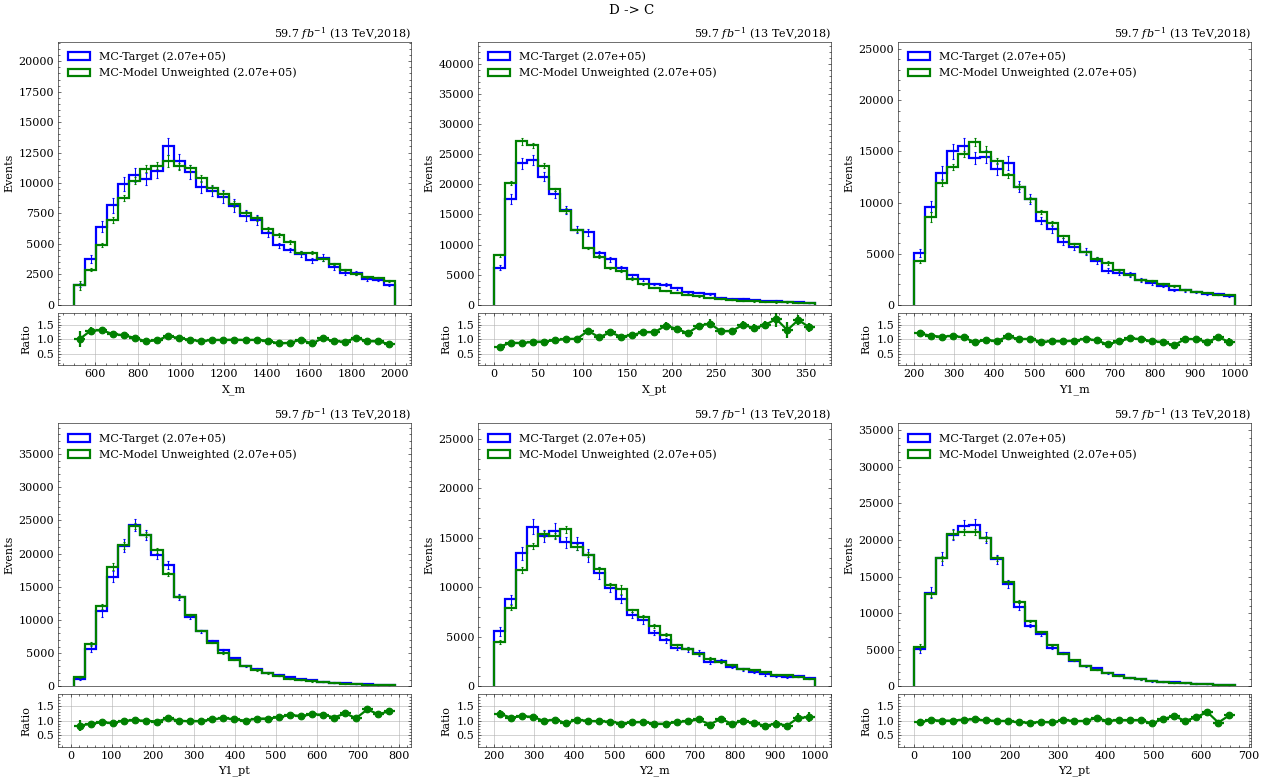

In [49]:
study.quick_region(
  bkg, bkg, label=['MC-Target','MC-Model Unweighted'],
  legend=True,
  masks=[bdt.c]*len(bkg) + [bdt.d]*len(bkg),
  scale=[1]*len(bkg) + [bdt.scale_tree]*len(bkg),
  varlist=features,
  ratio=True,
  title='D -> C'
)

100%|██████████| 6/6 [00:17<00:00,  2.87s/it]


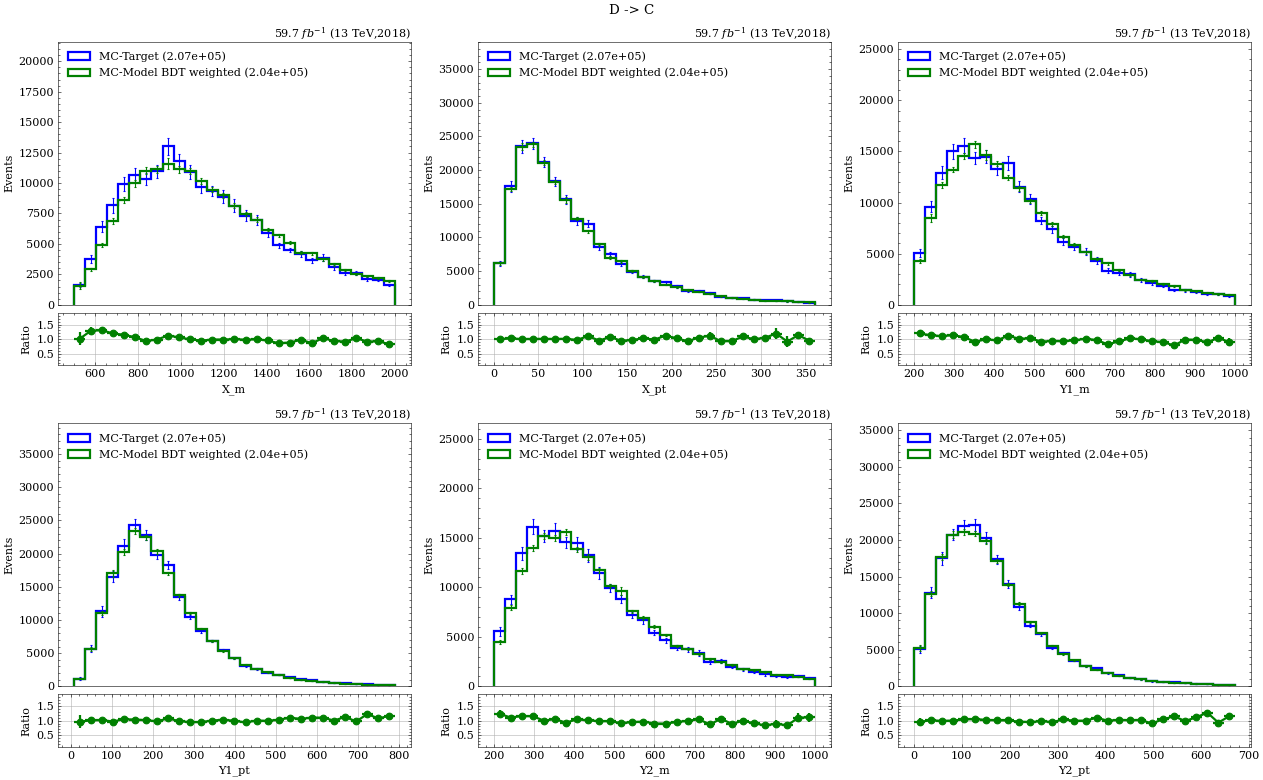

In [50]:
study.quick_region(
  bkg, bkg, label=['MC-Target','MC-Model BDT weighted'],
  legend=True,
  masks=[bdt.c]*len(bkg) + [bdt.d]*len(bkg),
  scale=[1]*len(bkg) + [bdt.reweight_tree]*len(bkg),
  varlist=features,
  ratio=True,
  title='D -> C'
)

100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


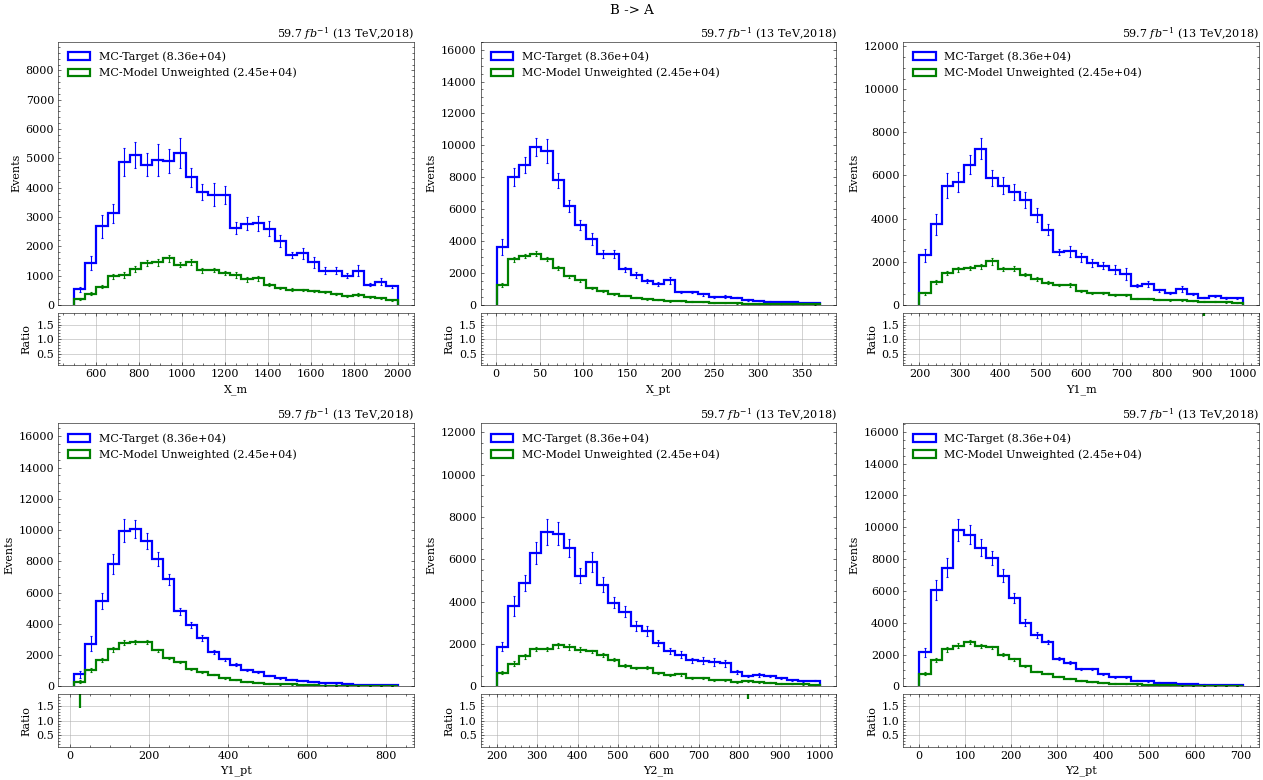

In [53]:
study.quick_region(
  bkg, bkg, label=['MC-Target','MC-Model Unweighted'],
  legend=True,
  masks=[bdt.a]*len(bkg) + [bdt.b]*len(bkg),
  scale=[1]*len(bkg) + [bdt.scale_tree]*len(bkg),
  varlist=features,
  ratio=True,
  title='B -> A'
)

100%|██████████| 6/6 [00:17<00:00,  2.89s/it]


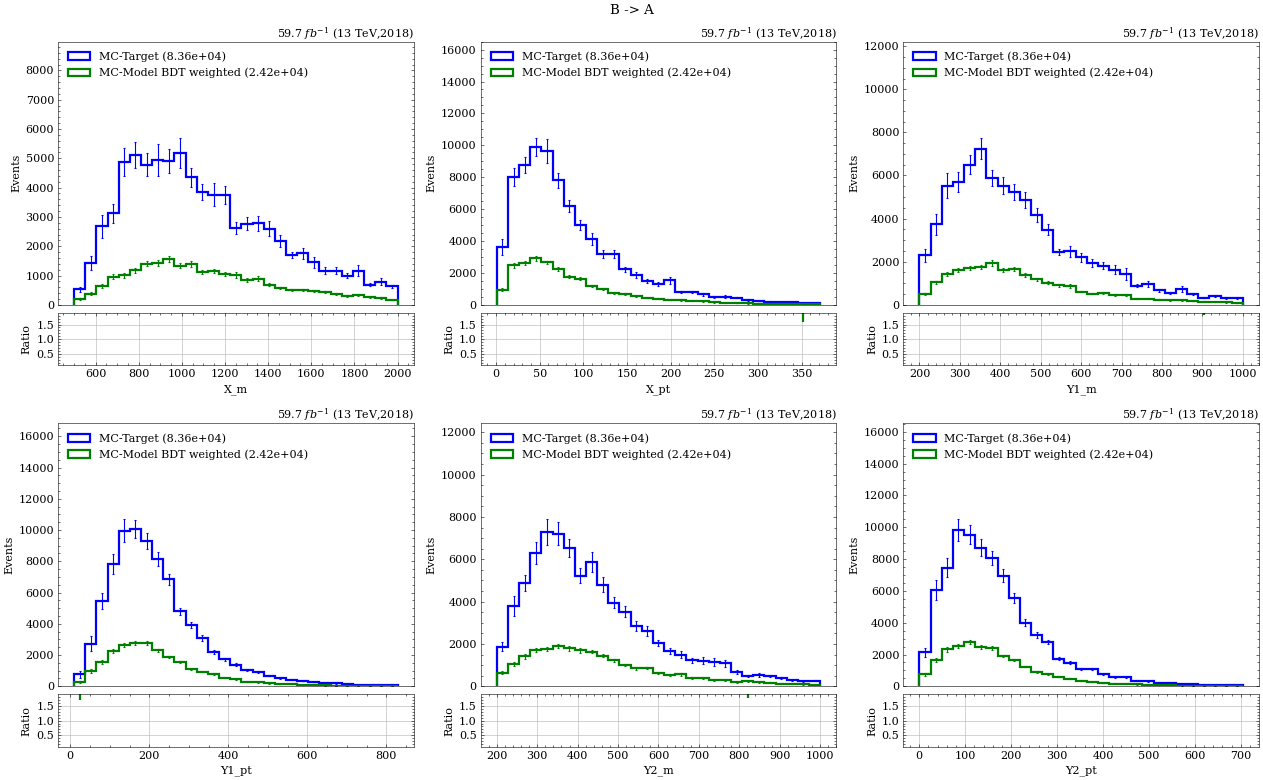

In [54]:
study.quick_region(
  bkg, bkg, label=['MC-Target','MC-Model BDT weighted'],
  legend=True,
  masks=[bdt.a]*len(bkg) + [bdt.b]*len(bkg),
  scale=[1]*len(bkg) + [bdt.reweight_tree]*len(bkg),
  varlist=features,
  ratio=True,
  title='B -> A'
)